In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

# List all files and folders in Google Drive
drive_path = "/content/drive/MyDrive"
files = os.listdir(drive_path)

print("Files in MyDrive:", files)

Files in MyDrive: ['DSC_7482.jpg', 'my-cv (1).pdf', 'Copy of my-cv.pdf', 'my-cv.pdf', 'Online Payment Options.pdf', 'Exchange Rate.gsheet', 'Colab Notebooks', 'ML', 'LR (1).docx', 'pp1.docx', 'Deliverable.docx', '2330907_20230221_Habarangamuwa.pdf', 'Lecture 2.pdf', 'dsgp (5).drawio', 'dsgp (4).drawio', 'dsgp (3).drawio', 'dsgp (2).drawio', 'dsgp (1).drawio', 'dsgp.drawio', 'Entry Level Tech Professional Resume (2) (1).pdf', 'Entry Level Tech Professional Resume (2).pdf', 'Resume Peer Review Form.docx', 'OOD', 'Plant_leaves_Datasets', 'maths1.ipynb', 'BananaK.zip', 'bananaMg.zip', 'Dsgp', 'Untitled30.ipynb', 'CoffeeMg.zip', 'CofeeeK.zip', 'CofeeIron.zip', 'BananaIron.zip', 'RiceN.zip', 'RiceP.zip', 'RiceK.zip']


In [3]:
dataset_path = "/content/drive/MyDrive/"

zip_files = [
    dataset_path + "BananaK.zip",
    dataset_path + "bananaMg.zip",
    dataset_path + "CoffeeMg.zip",
    dataset_path + "CofeeeK.zip",
    dataset_path + "BananaIron.zip",
    dataset_path + "CofeeIron.zip",
    dataset_path + "RiceN.zip",
    dataset_path + "RiceP.zip",
    dataset_path + "RiceK.zip"

]

In [4]:
import zipfile

# Extract each zip file
for zip_path in zip_files:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall("/content/datasets")

print("✅ All datasets extracted successfully!")

✅ All datasets extracted successfully!


In [5]:
extracted_folders = os.listdir("/content/datasets")
print("Extracted Folders:", extracted_folders)

Extracted Folders: ['potassium', 'iron-Fe', 'magnesium-Mg', 'Potassium(K)', 'Phosphorus(P)', 'magnesium', 'Nitrogen(N)', 'iron', 'potasium-K']


In [6]:
import cv2
import numpy as np
import os
from tensorflow.keras.preprocessing import image

# Function to preprocess images (resize and convert to RGB)
def preprocess_image(image_path):
    img = cv2.imread(image_path)  # Load the image
    img = cv2.resize(img, (224, 224))  # Resize to 224x224 for ResNet
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    return img

# Set paths for your datasets
dataset_path = "/content/datasets/"

# Prepare a list to store images and labels
images = []
labels = []

# Define severity levels (Mild, Moderate, Severe) for all deficiencies
severity_mapping = {
    # Banana & Coffee
    'magnesium': [1, 0, 0],    # Mild Magnesium
    'magnesium-Mg': [0, 1, 0], # Moderate Magnesium
    'potassium': [1, 0, 0],    # Mild Potassium
    'potasium-K': [0, 0, 1],   # Severe Potassium
    'iron': [0, 1, 0],         # Moderate Iron
    'iron-Fe': [0, 0, 1],      # Severe Iron

    # Rice Deficiencies
    'Potassium(K)': [1, 0, 0],  # Mild Potassium (Rice)
    'Nitrogen(N)': [0, 1, 0],   # Moderate Nitrogen
    'Phosphorus(P)': [0, 0, 1]  # Severe Phosphorus
}


# Load and preprocess images
for deficiency in severity_mapping:
    deficiency_path = os.path.join(dataset_path, deficiency)
    if os.path.exists(deficiency_path):  # Check if folder exists
        for img_name in os.listdir(deficiency_path):
            img_path = os.path.join(deficiency_path, img_name)
            img = preprocess_image(img_path)

            # Add the image and its label (mapped severity level)
            images.append(img)
            labels.append(severity_mapping[deficiency])
    else:
        print(f"⚠️ Warning: Directory '{deficiency}' not found, skipping...")

# Convert to numpy arrays
images = np.array(images)
labels = np.array(labels)

print(f"✅ {len(images)} images loaded and preprocessed successfully!")


✅ 1853 images loaded and preprocessed successfully!


In [7]:
from sklearn.model_selection import train_test_split

# Convert labels to numpy array
labels = np.array(labels)

# Convert one-hot labels to categorical labels (0,1,2) for stratification
labels_categorical = np.argmax(labels, axis=1)

# Split dataset into 80% training and 20% testing (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels_categorical
)

print(f"✅ Training data size: {len(X_train)} samples")
print(f"✅ Test data size: {len(X_test)} samples")


✅ Training data size: 1482 samples
✅ Test data size: 371 samples


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Define data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Initialize array with the same shape as X_train
X_train_augmented = np.zeros_like(X_train)

# Apply augmentation ONLY to training images
for i in range(len(X_train)):
    X_train_augmented[i] = next(datagen.flow(
        np.expand_dims(X_train[i], axis=0), batch_size=1
    ))[0]

print(f"✅ Data augmentation applied to {len(X_train_augmented)} images.")


✅ Data augmentation applied to 1482 images.


In [9]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
import numpy as np

# Load pre-trained ResNet50 model (without the top classification layer)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Function to extract features
def extract_features(images):
    features = []
    for img in images:
        img_array = img_to_array(img)  # Convert to array
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array = preprocess_input(img_array)  # Preprocess for ResNet50

        feature = base_model.predict(img_array)  # Extract features
        feature = feature.flatten()  # Flatten into 1D vector
        features.append(feature)

    return np.array(features)

# Extract features from training & test sets
X_train_features = extract_features(X_train_augmented)  # Training features (after augmentation)
X_test_features = extract_features(X_test)  # Test features (without augmentation)

print(f"✅ Feature extraction completed for 3 plants & 6 deficiencies! {X_train_features.shape[0]} training samples processed.")


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
Feature Map Shape: (1, 7, 7, 2048)


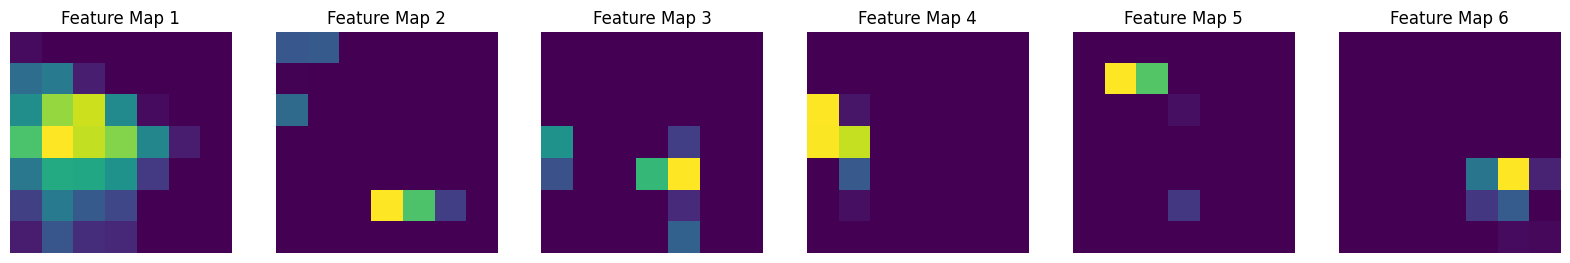

In [10]:
import matplotlib.pyplot as plt

# Function to extract and display multi-dimensional feature map
def extract_and_show_feature_map(img):
    img_array = img_to_array(img)  # Convert to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)  # Preprocess for ResNet50

    feature_map = base_model.predict(img_array)  # Extract multi-dimensional features

    print(f"Feature Map Shape: {feature_map.shape}")  # Print shape before flattening

    # Visualize feature map (only first 6 feature maps to avoid too many plots)
    num_features_to_show = min(6, feature_map.shape[-1])  # Limit to 6 channels
    fig, axes = plt.subplots(1, num_features_to_show, figsize=(20, 5))

    for i in range(num_features_to_show):
        axes[i].imshow(feature_map[0, :, :, i], cmap='viridis')  # Show feature map for each channel
        axes[i].axis('off')
        axes[i].set_title(f'Feature Map {i+1}')

    plt.show()

# Test with a random image from the training set
extract_and_show_feature_map(X_train_augmented[0])


In [11]:
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1482, 3)
y_test shape: (371, 3)


In [12]:
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Build the model
model = models.Sequential([
    layers.Dense(256, activation='relu', input_dim=X_train_features.shape[1]),  # Adjusted for new dataset
    layers.Dropout(0.6),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(3, activation='softmax')  # Output remains 3 classes: Mild, Moderate, Severe
])

# Compile the model
model.compile(optimizer=RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])

# Early Stopping and Learning Rate Scheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Model summary
model.summary()

# Train the model with callbacks
history = model.fit(X_train_features, y_train, epochs=30, batch_size=32, validation_data=(X_test_features, y_test), callbacks=[early_stopping, reduce_lr])

# Evaluate model on test set
test_loss, test_accuracy = model.evaluate(X_test_features, y_test)
print(f"✅ Test Accuracy: {test_accuracy * 100:.2f}%")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │      25,690,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,748,227 (98.22 MB)

 Trainable params: 25,748,227 (98.22 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 28s 506ms/step - accuracy: 0.3544 - loss: 19.4352 - val_accuracy: 0.4609 - val_loss: 1.1075 - learning_rate: 0.0010
Epoch 2/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 28s 600ms/step - accuracy: 0.4155 - loss: 2.3003 - val_accuracy: 0.5418 - val_loss: 1.0293 - learning_rate: 0.0010
Epoch 3/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 37s 512ms/step - accuracy: 0.3983 - loss: 1.4780 - val_accuracy: 0.4447 - val_loss: 1.0307 - learning_rate: 0.0010
Epoch 4/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 42s 534ms/step - accuracy: 0.4219 - loss: 1.3687 - val_accuracy: 0.6011 - val_loss: 0.9944 - learning_rate: 0.0010
Epoch 5/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 40s 506ms/step - accuracy: 0.4406 - loss: 1.2621 - val_accuracy: 0.5714 - val_loss: 0.9990 - learning_rate: 0.0010
Epoch 6/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 41s 508ms/step - accuracy: 0.4881 - loss: 1.0900 - val_accuracy: 0.7251 - val_loss: 0.7898 - learning_rate: 0.0010
Epoch 7/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 42s 530ms/step - accuracy: 0.5277 - loss: 1

In [13]:
# Print training accuracy for each epoch
print(f"Training Accuracy: {history.history['accuracy']}")

# Optionally, get the final training accuracy after the last epoch
final_training_accuracy = history.history['accuracy'][-1]
print(f"Final Training Accuracy: {final_training_accuracy * 100:.2f}%")

Training Accuracy: [0.36032387614250183, 0.4176788032054901, 0.41970309615135193, 0.4385964870452881, 0.4615384638309479, 0.49257761240005493, 0.5242915153503418, 0.5661268830299377, 0.5897436141967773, 0.6275303363800049, 0.6808366775512695, 0.7031038999557495, 0.711875855922699, 0.7523616552352905, 0.7732793688774109, 0.7800269722938538, 0.7995951175689697, 0.8205128312110901, 0.8218623399734497, 0.8049932718276978, 0.8151147365570068, 0.8515519499778748]
Final Training Accuracy: 85.16%


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step


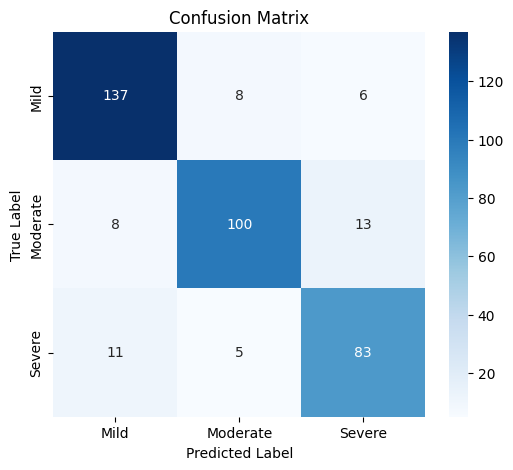

Classification Report:
               precision    recall  f1-score   support

        Mild       0.88      0.91      0.89       151
    Moderate       0.88      0.83      0.85       121
      Severe       0.81      0.84      0.83        99

    accuracy                           0.86       371
   macro avg       0.86      0.86      0.86       371
weighted avg       0.86      0.86      0.86       371



In [14]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get model predictions
y_pred = model.predict(X_test_features)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
y_true_classes = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class labels

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Mild', 'Moderate', 'Severe'], yticklabels=['Mild', 'Moderate', 'Severe'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print classification report for precision, recall, F1-score
print("Classification Report:\n", classification_report(y_true_classes, y_pred_classes, target_names=['Mild', 'Moderate', 'Severe']))

In [15]:
from tensorflow.keras.models import save_model
from google.colab import files

# Define model save path
model_save_path = "/content/severity_classification_model.h5"

# Save the trained model
save_model(model, model_save_path)
print(f"✅ Model saved successfully at {model_save_path}")

# Download the model
files.download(model_save_path)


✅ Model saved successfully at /content/severity_classification_model.h5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>